# INSY 7120 Final Project

## Data Selection

The guidelines of for dataset selection in this project are listed here:
- Find a *real-world* dataset of your choice on Kaggle, UCI ML Repository, or other sources
- You may also use data from your research, but it must meet the other requirments
- **Dataset must be non-trivial**:
  -  Minimum 1,000 observations
  - Minimum 10 features
  - Smaller datasets require instructor approval
- **Excluded datasets:**
  - Titanic dataset
  - Any dataset used in ISL textbook
  - Any dataset included in scikit-learn (e.g., Iris, Boston Housing)
  - Any dataset used in class examples or homework
  - Other example / toy / educational datasets of this sort


The dataset used for the project comes from queried data using SQL on real IBM Maximo workorder data in a specific department within an automotive manufacturing plant that has been anonomyzed for confidentiality purposes. The details of this dataset can be found [here](https://github.com/Kwillhide770/INSY-7120-Final-Project/raw/main/Maximo_Anonymized_Dataset_Documentation.pdf).

I also included a Data Dictionary indicating the description, data type, measurement type, and examples of the data. This can be found below under [Data Dictionary](#scrollTo=PQ3ZysTo_XjH).

## Problem Definition

### Problem Statement



The automotive manufacturing industry relies heavily on equipment availabilty to make target production numbers. Minimizing equipment downtime is crucial for its operation and just minutes of downtime can be very costly. Using historical IBM Maximo workorder data, the goal of this project is to build a predictive model that can estimate the total downtime from the top 10 assets with the most downtime within a department of the an automotive plant.

### Why This Matters

- Predicting downtime allows maintenance planners to better prioritize tasks such as **weekend work planning** and **spare parts optimization**.
- Early insight into downtime severity can assist in **budgeting future investments** and identifying gaps in systemic failures such as **weak training programs, insufficient management of manpower, poor recovery procedures, or suboptimal design of equipment**.

### Project Objective

Develop and evaluate several regression models to predict **`HNATOTALDT`** using features such as failure codes, shift, date, crew, and location (line). The focus is to build **interpretable** and **accurate** models for operational decision-making to maximize **availability** of equipment.


## Data Exploration

### Data Dictionary


Below is a data dictionary to assist in the understanding of the dataset used.

| Column Name|Description | Data Type | Measurement Type | Example |
|------------------|------------------------------------------------------------------------|------------|-------------------------------|-------------------|
| `WONUM` | Anonymized Work Order Number identifier | String | Categorical (Nominal) | `WONUM_042` |
| `ASSETNUM` | Anonymized Asset identifier involved in the work order | String | Categorical (Nominal) | `ASSET_117` |
| `LINE` | Anonymized production line associated with the asset | String | Categorical (Nominal) | `LINE_008` |
| `HNATOTALDT` | Total downtime (in minutes) for the work order | Integer | Numerical (Continuous) | `60` |
| `HNACOMMODITY` | Code representing the commodity type of the asset | String | Categorical (Nominal) | `CMP` |
| `FAILURECODE`    | Code describing the nature of failure | String | Categorical (Nominal) | `BRGFAIL` |
| `PROBLEM_CODE` | Code describing the reported problem | String | Categorical (Nominal) | `VIBRATION` |
| `CAUSE_CODE` | Code describing the root cause of the failure | String | Categorical (Nominal) | `LUBRIC` |
| `REMEDY_CODE` | Code describing the remedy or fix applied | String | Categorical (Nominal) | `REPLBRG` |
| `LEAD` | Anonymized lead technician responsible for the work order | String | Categorical (Nominal) | `LEAD_012` |
| `SUPERVISOR` | Anonymized supervisor associated with the work order | String | Categorical (Nominal) | `SUP_003` |
| `LABOR_COUNT` | Number of unique technicians who worked on the job | Integer | Numerical (Discrete) | `3` |
| `LABORHOURS` | Total labor hours spent on the work order | Float | Numerical (Continuous) | `4.5` |
| `dt<=5` | Indicator for short-duration downtime (<= 5 minutes) | Integer | Categorical (Binary) | `1` (Yes), `0` (No) |
| `SHIFT` | Work shift during which the job was performed | Integer | Categorical (Ordinal) | `2` |
| `CREW` | Crew number assigned to the job | Integer | Categorical (Nominal) | `104` |
| `DATE` | Date of the downtime event | Datestamp | Categorical (Ordinal) | `2024-08-14` |
| `WEEKDAYNUM` | Day of the week the work was reported (1=Sunday, ..., 7=Saturday) | Integer | Categorical (Ordinal) | `3` |
| `ISWEEKEND` | Indicator if the job occurred on a weekend | Integer | Categorical (Binary) | `1` (Yes), `0` (No) |

### Loading the Data

In [1]:
# Import necessary libraries
# !pip install optuna # if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, get_scorer_names
from sklearn.model_selection import train_test_split, cross_val_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from IPython.display import display
import shap

This dataset is loaded in from my personal github repository for this project. You can access it [here](https://github.com/Kwillhide770/INSY-7120-Final-Project).

In [2]:
# Load the data into a dataframe
url = "https://raw.githubusercontent.com/Kwillhide770/INSY-7120-Final-Project/main/anonymized_dataset.csv"
df = pd.read_csv(url)

In [3]:
df.head(2)

WONUM   ASSETNUM      LINE  HNATOTALDT HNACOMMODITY FAILURECODE  \
0  WONUM_1373  ASSET_009  LINE_001           1         WIRE  MECHANICAL   
1  WONUM_1774  ASSET_010  LINE_004          75       SWITCH  ELECTRICAL   

  PROBLEM_CODE CAUSE_CODE REMEDY_CODE      LEAD SUPERVISOR  LABOR_COUNT  \
0     STICKING       MISC      ADJUST  LEAD_032    SUP_007          3.0   
1    NOPWRVOLT       MISC     REPLACE  LEAD_039    SUP_010          3.0   

   LABORHOURS  dt<=5  SHIFT  CREW        DATE  WEEKDAYNUM  ISWEEKEND  
0        3.00      1      3     0  2022-12-19           2          0  
1        4.25      0      1     1  2023-01-23           2          0

### Basic Information about the Dataset

In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (1986, 19)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   WONUM         1986 non-null   object 
 1   ASSETNUM      1986 non-null   object 
 2   LINE          1986 non-null   object 
 3   HNATOTALDT    1986 non-null   int64  
 4   HNACOMMODITY  1986 non-null   object 
 5   FAILURECODE   1986 non-null   object 
 6   PROBLEM_CODE  1986 non-null   object 
 7   CAUSE_CODE    1986 non-null   object 
 8   REMEDY_CODE   1986 non-null   object 
 9   LEAD          1986 non-null   object 
 10  SUPERVISOR    1986 non-null   object 
 11  LABOR_COUNT   1985 non-null   float64
 12  LABORHOURS    1985 non-null   float64
 13  dt<=5         1986 non-null   int64  
 14  SHIFT         1986 non-null   int64  
 15  CREW          1986 non-null   int64  
 16  DATE          1986 non-null   object 
 17  WEEKDAYNUM    1986 non-null   int64  
 18  ISWEEKEND     1986 non-null 

In [6]:
df.describe()

HNATOTALDT  LABOR_COUNT   LABORHOURS        dt<=5        SHIFT  \
count   1986.000000  1985.000000  1985.000000  1986.000000  1986.000000   
mean     111.397281     2.346599     3.923333     0.046324     2.088620   
std      639.892947     1.250310     7.707295     0.210239     0.847103   
min        0.000000     1.000000     0.016667     0.000000     1.000000   
25%       18.000000     2.000000     1.000000     0.000000     1.000000   
50%       30.000000     2.000000     2.000000     0.000000     2.000000   
75%       65.000000     3.000000     4.000000     0.000000     3.000000   
max    24825.000000    17.000000   138.500000     1.000000     3.000000   

              CREW   WEEKDAYNUM    ISWEEKEND  
count  1986.000000  1986.000000  1986.000000  
mean      0.479355     3.936556     0.114300  
std       0.499699     1.655767     0.318256  
min       0.000000     1.000000     0.000000  
25%       0.000000     3.000000     0.000000  
50%       0.000000     4.000000     0.000000  
75%       1.000000     5.000000     0.000000  
max       1.000000     7.000000     1.000000

### Initial Insights

Key insights from the description statistics:

- **`HNATOTALDT`**:
  - Mean = 111.45
  - Median = 30
  - Max= 24825
  - Standard Deviation = 640
  - **Heavily skewed to the right**
- **`Labor_Count`**:
  - Max = 17
  - 75% = 3
  - **The max value is an outlier**
- **`Labor_Hours`**:
  - Max = 138
  - 75% = 4
  - **The max value is an outlier**
- **`dt<=5`**:
  - Mean = 0.04
  - **Very few short stop downtime events**
- **`ISWEEKEND`**:
  - Mean = 0.11
  - **Very few weekend downtime events**


### Data Visualization

#### HNATOTALDT Distribution (Target Variable)

Since the target variable has a large skew to the right (seen from the max vs mean), the log was visualized and used to stabilize the variance. This will be used later.

In [7]:
# Use log transformation to normalize the skewed data

df['LOG_HNATOTALDT'] = np.log1p(df['HNATOTALDT'])

In [8]:
# Distribution of Downtime, using both HNATOTALDT and LOG_HNATOTALDT
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(df['HNATOTALDT'], bins=50, kde=True)
plt.title("Original Downtime (Minutes)")

plt.subplot(1,2,2)
sns.histplot(df['LOG_HNATOTALDT'], bins=50, kde=True)
plt.title("Log-Transformed Downtime")
plt.tight_layout()
plt.show()

#### Labor vs Downtime

Below shows the relationship between labor (hours+count) and downtime.

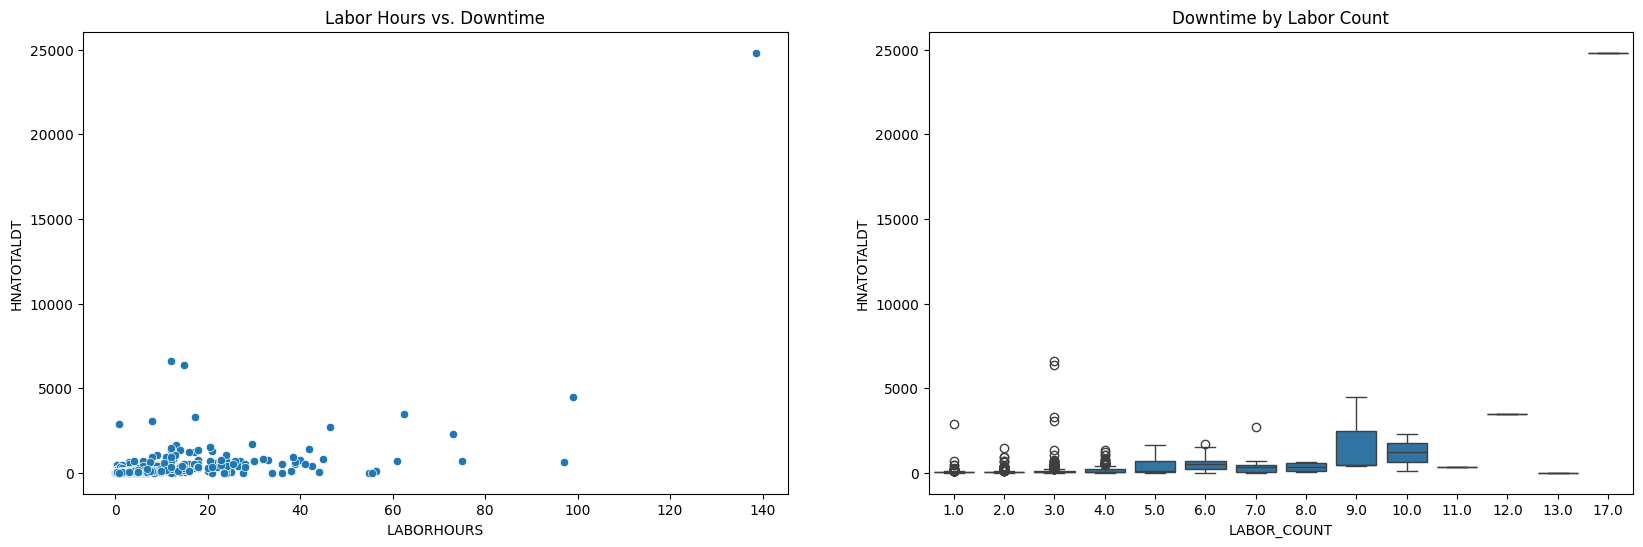

In [9]:
# Scatterplot for Labor Hours
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
sns.scatterplot(x='LABORHOURS', y='HNATOTALDT', data=df)
plt.title("Labor Hours vs. Downtime")

# Boxplot for Labor Count
plt.subplot(1,2,2)
sns.boxplot(x='LABOR_COUNT', y='HNATOTALDT', data=df)
plt.title("Downtime by Labor Count")
plt.show()

#### Downtime Over Time

The date was converted into Month and Year to get a monthly trend and to see if there can be any pattern from it.

In [10]:
# Convert DATE to datetime (Helpful for using date operations)
df['DATE'] = pd.to_datetime(df['DATE'])

# Add Month and Year columns
df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year

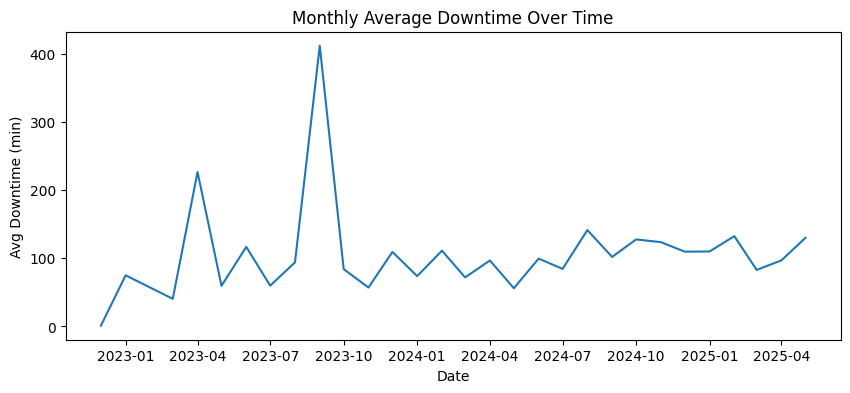

In [11]:
# Average Downtime Over Time
monthly_trend = df.groupby(['YEAR','MONTH'])['HNATOTALDT'].mean().reset_index()
monthly_trend['Date'] = pd.to_datetime(monthly_trend[['YEAR', 'MONTH']].assign(DAY=1))

plt.figure(figsize=(10,4))
sns.lineplot(data=monthly_trend, x='Date', y='HNATOTALDT')
plt.title("Monthly Average Downtime Over Time")
plt.ylabel("Avg Downtime (min)")
plt.xlabel("Date")
plt.show()

Below are plots to represent different time features. ANOVA was taken on the data to determine the f-stat and p_value to test against the null hypothesis.

In [12]:
def boxplot_and_anova(df, cat_col, target_col='LOG_HNATOTALDT', figsize=(12, 4)):
    plt.figure(figsize=figsize)
    sns.boxplot(x=cat_col, y=target_col, data=df)
    plt.title(f'{target_col} by {cat_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    groups = [df[target_col][df[cat_col] == level] for level in df[cat_col].unique()]
    f_stat, p_val = stats.f_oneway(*groups)
    print(f"ANOVA for {cat_col}: F = {f_stat:.2f}, p = {p_val:.4f}")

    if p_val < 0.05:
        print(f"→ The difference in mean {target_col} across {cat_col} levels is statistically significant.\n")
    else:
        print(f"→ No significant difference in mean {target_col} across {cat_col} levels.\n")

    anova_results.append({
        'Target': target_col,
        'Predictor': cat_col,
        'F-statistic': f_stat,
        'p-value': p_val
    })

    return f_stat, p_val

anova_results = []

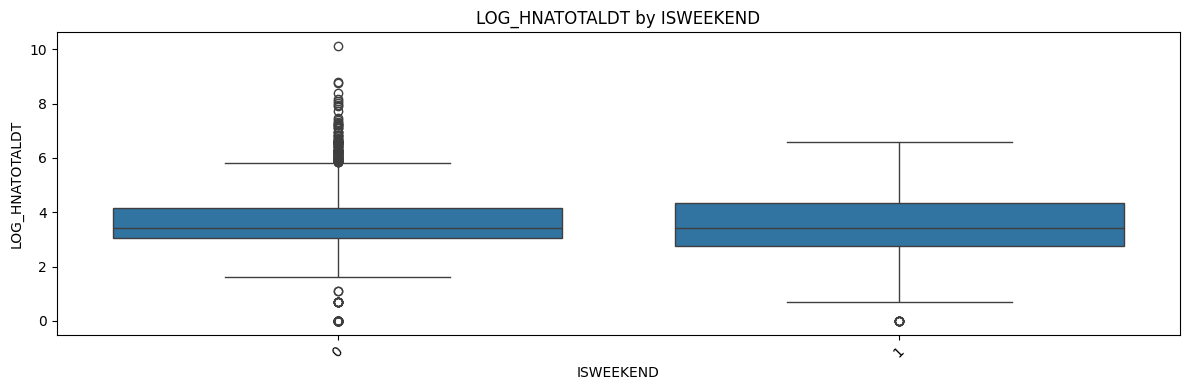

ANOVA for ISWEEKEND: F = 1.40, p = 0.2369
→ No significant difference in mean LOG_HNATOTALDT across ISWEEKEND levels.



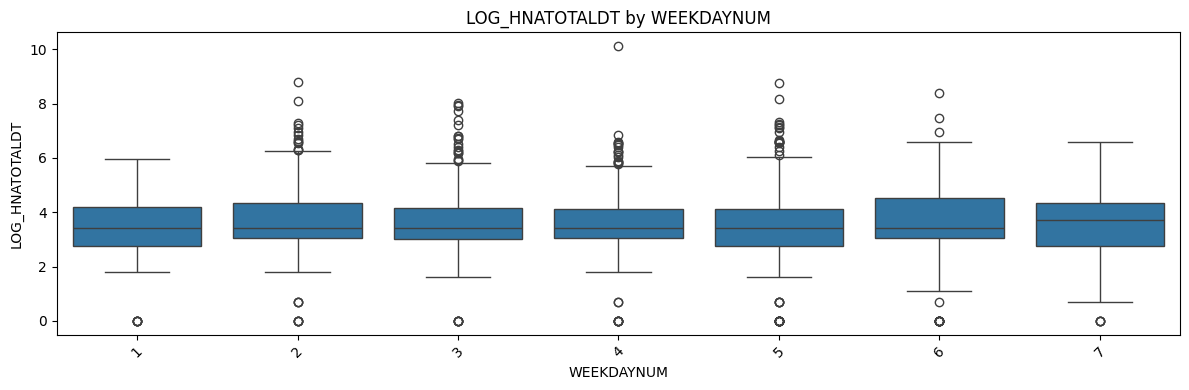

ANOVA for WEEKDAYNUM: F = 0.97, p = 0.4438
→ No significant difference in mean LOG_HNATOTALDT across WEEKDAYNUM levels.



ANOVA for MONTH: F = 1.12, p = 0.3429
→ No significant difference in mean LOG_HNATOTALDT across MONTH levels.



(np.float64(1.117420663859744), np.float64(0.3428658197402762))

In [13]:
figsize = (12,4)
boxplot_and_anova(df, 'ISWEEKEND')
boxplot_and_anova(df, 'WEEKDAYNUM')
boxplot_and_anova(df, 'MONTH')

All three features failed against the null hypothesis, deeming then to have little/no significance.

#### Failure Codes

Below are plots + ANOVA weighing the failure codes against the log downtime.

ANOVA for HNACOMMODITY: F = 2.18, p = 0.0000
→ The difference in mean LOG_HNATOTALDT across HNACOMMODITY levels is statistically significant.



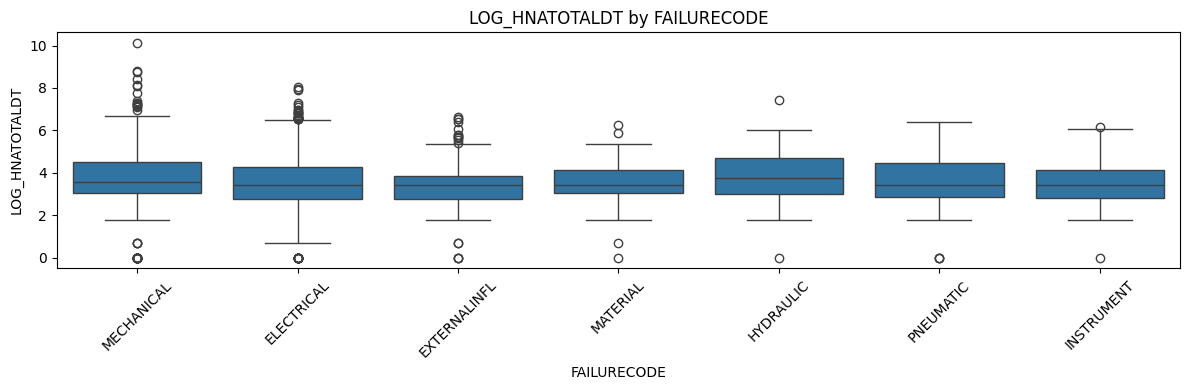

ANOVA for FAILURECODE: F = 1.74, p = 0.1071
→ No significant difference in mean LOG_HNATOTALDT across FAILURECODE levels.



ANOVA for PROBLEM_CODE: F = 2.06, p = 0.0005
→ The difference in mean LOG_HNATOTALDT across PROBLEM_CODE levels is statistically significant.



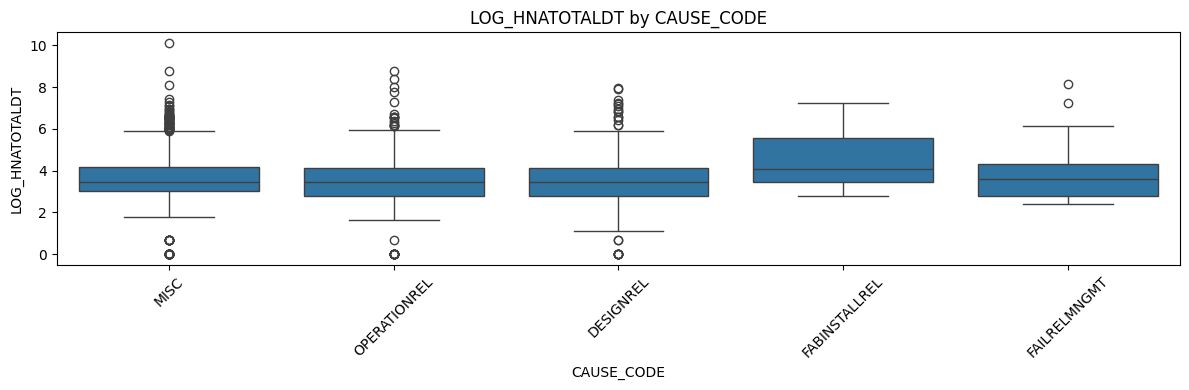

ANOVA for CAUSE_CODE: F = 3.75, p = 0.0048
→ The difference in mean LOG_HNATOTALDT across CAUSE_CODE levels is statistically significant.



ANOVA for REMEDY_CODE: F = 18.65, p = 0.0000
→ The difference in mean LOG_HNATOTALDT across REMEDY_CODE levels is statistically significant.



(np.float64(18.65485563198043), np.float64(3.2029234443558092e-24))

In [14]:
figsize = (12,4)
boxplot_and_anova(df, 'HNACOMMODITY')
boxplot_and_anova(df, 'FAILURECODE')
boxplot_and_anova(df, 'PROBLEM_CODE')
boxplot_and_anova(df, 'CAUSE_CODE')
boxplot_and_anova(df, 'REMEDY_CODE')

The different failure codes excluding the Problem Code show statistical significance. Notice the large count of categories within the HNACOMMODITY feature. If the number of observations were much higher, this might be useful, but this large number of categories might prevent strong testing with our small count of observations.

#### Line Predictors

Below are plots + ANOVA weighing the different line-side features against the log downtime.

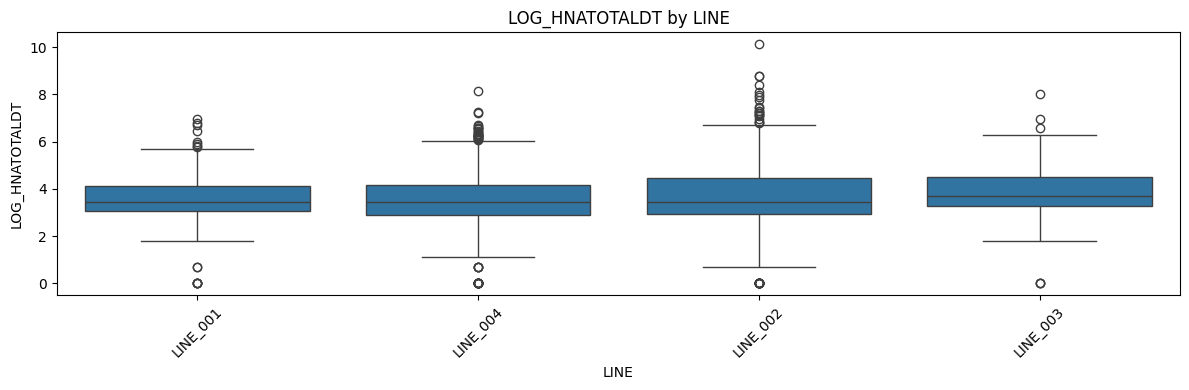

ANOVA for LINE: F = 2.05, p = 0.1044
→ No significant difference in mean LOG_HNATOTALDT across LINE levels.



ANOVA for SUPERVISOR: F = 1.39, p = 0.1790
→ No significant difference in mean LOG_HNATOTALDT across SUPERVISOR levels.



ANOVA for LEAD: F = 3.77, p = 0.0000
→ The difference in mean LOG_HNATOTALDT across LEAD levels is statistically significant.



ANOVA for SHIFT: F = 2.95, p = 0.0526
→ No significant difference in mean LOG_HNATOTALDT across SHIFT levels.



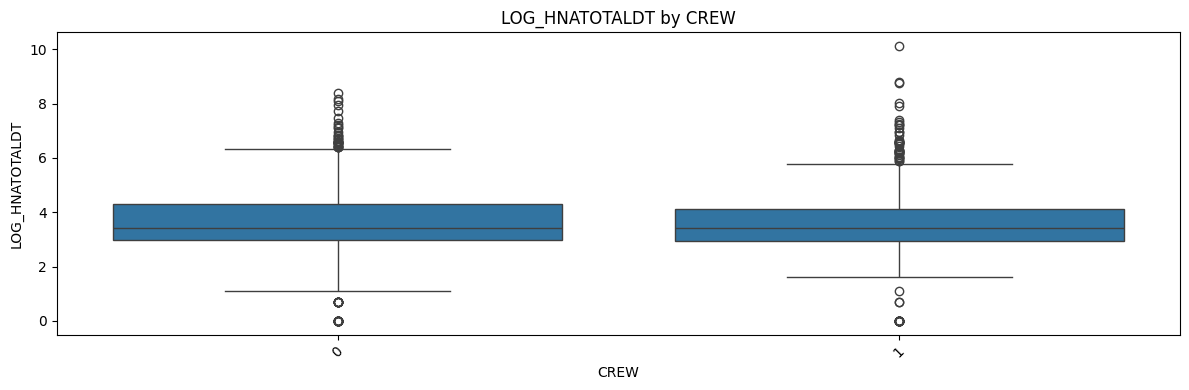

ANOVA for CREW: F = 0.36, p = 0.5473
→ No significant difference in mean LOG_HNATOTALDT across CREW levels.



(np.float64(0.3623160660670944), np.float64(0.5472915344981885))

In [15]:
figsize = (14,6)
boxplot_and_anova(df, 'LINE')
boxplot_and_anova(df, 'SUPERVISOR')
boxplot_and_anova(df, 'LEAD')
boxplot_and_anova(df, 'SHIFT')
boxplot_and_anova(df, 'CREW')

While there is good evidence against the null hypothesis for the Lead feature, once again, there are alot of different people within the feature. This may not be useful when performing the One Hot Encoding.

#### Heat Map

Below is a correlation heatmap to visualize highly correlated features.

In [16]:
# Correlation Heatmap

numeric_cols = ['LOG_HNATOTALDT', 'LABORHOURS', 'LABOR_COUNT', 'SHIFT', 'WEEKDAYNUM', 'ISWEEKEND']
plt.figure(figsize=(8,6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

#### Summary of Visualizations

In [17]:
# ANOVA Positive Results

print("\nANOVA Results (p <0.05):")
for result in sorted(anova_results, key=lambda x: x['p-value'], reverse=True):
  if result['p-value'] < 0.05:
    print(f"\nTarget: {result['Target']}, Predictor: {result['Predictor']}, F-statistic: {result['F-statistic']:.2f}, p-value: {result['p-value']:.4f}")


ANOVA Results (p <0.05):

Target: LOG_HNATOTALDT, Predictor: CAUSE_CODE, F-statistic: 3.75, p-value: 0.0048

Target: LOG_HNATOTALDT, Predictor: PROBLEM_CODE, F-statistic: 2.06, p-value: 0.0005

Target: LOG_HNATOTALDT, Predictor: HNACOMMODITY, F-statistic: 2.18, p-value: 0.0000

Target: LOG_HNATOTALDT, Predictor: LEAD, F-statistic: 3.77, p-value: 0.0000

Target: LOG_HNATOTALDT, Predictor: REMEDY_CODE, F-statistic: 18.65, p-value: 0.0000


In [18]:
# ANOVA Negative Results

print("\nANOVA Results (p >=0.05):")
for result in sorted(anova_results, key=lambda x: x['p-value'], reverse=True):
  if result['p-value'] >= 0.05:
    print(f"\nTarget: {result['Target']}, Predictor: {result['Predictor']}, F-statistic: {result['F-statistic']:.2f}, p-value: {result['p-value']:.4f}")


ANOVA Results (p >=0.05):

Target: LOG_HNATOTALDT, Predictor: CREW, F-statistic: 0.36, p-value: 0.5473

Target: LOG_HNATOTALDT, Predictor: WEEKDAYNUM, F-statistic: 0.97, p-value: 0.4438

Target: LOG_HNATOTALDT, Predictor: MONTH, F-statistic: 1.12, p-value: 0.3429

Target: LOG_HNATOTALDT, Predictor: ISWEEKEND, F-statistic: 1.40, p-value: 0.2369

Target: LOG_HNATOTALDT, Predictor: SUPERVISOR, F-statistic: 1.39, p-value: 0.1790

Target: LOG_HNATOTALDT, Predictor: FAILURECODE, F-statistic: 1.74, p-value: 0.1071

Target: LOG_HNATOTALDT, Predictor: LINE, F-statistic: 2.05, p-value: 0.1044

Target: LOG_HNATOTALDT, Predictor: SHIFT, F-statistic: 2.95, p-value: 0.0526


1. **HNATOTALDT (Target Variable):**
  - Skewed heavily to the right with few extreme outliers.
  - Can use LOG_HNATOTALDT as target for regression to assist with modeling.

2. Labor Features:
  - Labor Hours has a wide spread, positively correlated.
  - Labor Count has moderate correlation (potential multicollinearity).
  - Labor Hours an Count would not be a useful metric as they are results of high downtime. This data could be useful in other applications, but not for prediction of downtime events. (There may be a case for using Labor Count/Labor Hours as you could identify where downtime is extended due to low manpower, but for the sake of this project, this data will be removed.

3. Time Features:
  - Day of week/weekends do not show strong correlation.
  - Month of the year also does not have a strong correlation.

4. Failure Codes:
  - Using the log of the target, HNACOMMODITY has a fairly strong correlation.
  - The problem, cause, and remedy codes show great promise to benefit prediction.
  - The remedy code resulted with the strongest F-stat.
  - The failure code shows little correlation.

5. Line Predictors:
  - Line 2 has noticeably more outliers, although all 4 lines tend to have a similar median, with Line 3 and 4 slightly tighter in variance. The line appears to have a good p_value as well.
  - Supervisor 4 and 6 may have very little datapoints which could mean that they may not be useful to use for our models (potentially could combine with other low frequency supervisors into an other category). It did pass the null hypothesis against the target.
  - Lead has a fairly large amount of both within-group and between-group variance. This could potentially provide some predictive power. Both the target and the log_target have a great p and f statistic.
  - Day crew and night crew do not have much value but may benefit when combining with the shift and supervisor. The p and f statistics are weak.

6. Heat Map:
  - The heat map shows the most correlation between labor and the downtime. This makes sense as the more downtime the workorder has, the labor hours and count would increase. These values would not be benefitial for prediction though as they would not be able to be utilized.

## Data Preparation

#### Feature Engineering

To prepare the data for the models, I will begin by removing unneeded columns, but first, there is a huge outlier in the target variable I want to remove. Since I aware of the background of this dataset, I know about this outlier and that this specific observation is faulty and untrue.

In [19]:
# View the row with the largest value

df.sort_values(by='HNATOTALDT', ascending=False).head(3)

WONUM   ASSETNUM      LINE  HNATOTALDT HNACOMMODITY FAILURECODE  \
473   WONUM_1282  ASSET_008  LINE_002       24825       LINEAR  MECHANICAL   
72    WONUM_1023  ASSET_005  LINE_002        6590         HOSE  MECHANICAL   
1791  WONUM_1426  ASSET_006  LINE_002        6360       PALLET  MECHANICAL   

        PROBLEM_CODE    CAUSE_CODE REMEDY_CODE      LEAD  ...  LABORHOURS  \
473        LOOSENESS          MISC     REPLACE  LEAD_009  ...  138.500000   
72           LEAKAGE          MISC     REPLACE  LEAD_043  ...   12.083333   
1791  CLEARALIGNFAIL  OPERATIONREL       CLEAN  LEAD_023  ...   15.000000   

      dt<=5  SHIFT  CREW       DATE  WEEKDAYNUM ISWEEKEND  LOG_HNATOTALDT  \
473       0      2     1 2023-09-13           4         0       10.119647   
72        0      2     1 2023-04-24           2         0        8.793460   
1791      0      1     1 2025-02-20           5         0        8.757941   

      MONTH  YEAR  
473       9  2023  
72        4  2023  
1791      2  2025  

[3 rows x 22 columns]

In [20]:
# Remove the top row
df = df[df['HNATOTALDT'] != df['HNATOTALDT'].max()].copy()
df['LOG_HNATOTALDT'] = np.log1p(df['HNATOTALDT'])

In [21]:
# Confirm it is removed

df['HNATOTALDT'].max()

6590

Now to evaluate the features to drop.

In [22]:
# View the count of unique values in each feature

cat_unique = pd.DataFrame({
    'Unique Values': df.nunique(),
    'Data Type': df.dtypes
}).sort_values(by='Unique Values', ascending=False)

print(cat_unique)

                Unique Values       Data Type
WONUM                    1985          object
DATE                      603  datetime64[ns]
LOG_HNATOTALDT            223         float64
HNATOTALDT                223           int64
LABORHOURS                167         float64
HNACOMMODITY              112          object
LEAD                       44          object
PROBLEM_CODE               32          object
LABOR_COUNT                13         float64
MONTH                      12           int32
SUPERVISOR                 11          object
ASSETNUM                   10          object
REMEDY_CODE                 8          object
FAILURECODE                 7          object
WEEKDAYNUM                  7           int64
CAUSE_CODE                  5          object
LINE                        4          object
YEAR                        4           int32
SHIFT                       3           int64
dt<=5                       2           int64
CREW                        2     

In [23]:
# To avoid running into issues, rename

df.rename(columns={'dt<=5': 'dt5'}, inplace=True)

In [24]:
# Confirm the name

df.head(1)

WONUM   ASSETNUM      LINE  HNATOTALDT HNACOMMODITY FAILURECODE  \
0  WONUM_1373  ASSET_009  LINE_001           1         WIRE  MECHANICAL   

  PROBLEM_CODE CAUSE_CODE REMEDY_CODE      LEAD  ... LABORHOURS  dt5  SHIFT  \
0     STICKING       MISC      ADJUST  LEAD_032  ...        3.0    1      3   

   CREW       DATE  WEEKDAYNUM ISWEEKEND  LOG_HNATOTALDT  MONTH  YEAR  
0     0 2022-12-19           2         0        0.693147     12  2022  

[1 rows x 22 columns]

In [25]:
df['CAUSE_CODE'].value_counts()

CAUSE_CODE
MISC             1445
OPERATIONREL      311
DESIGNREL         181
FAILRELMNGMT       28
FABINSTALLREL      20
Name: count, dtype: int64

In [26]:
df['LINE'].value_counts()

LINE
LINE_004    785
LINE_002    740
LINE_001    401
LINE_003     59
Name: count, dtype: int64

Line_003 does not have many observations and may be difficult to really help with our prediction, so it will be removed.

In [27]:
df = df[df['LINE'] != 'LINE_003']

In [28]:
df['YEAR'].value_counts()

YEAR
2024    903
2023    726
2025    296
2022      1
Name: count, dtype: int64

Since YEAR only has one observation in 2022, it will be removed as well.

In [29]:
df = df[df['YEAR'] != 2022]

- The workorder number, date, and year will be removed since they would not be predictors.
- Lead, Problem Code, and HNACOMMODITY may have too many values and will end up overfitting our data if we use them.
- I went ahead and removed them as well. The Cause Code did not seem beneficial with most of its values listed as MISC.
- Supervisor was removed because the original data that this comes from is not very good.

In [30]:
# Set array for columns to drop

drop_cols = ['WONUM',
             'DATE',
             'YEAR',
             'LEAD',
             'SUPERVISOR',
             'PROBLEM_CODE',
             'CAUSE_CODE',
             'HNACOMMODITY']

In [31]:
# Drop the array

df_model = df.drop(columns=drop_cols)

In [32]:
# View the count of unique values in each feature

cat_unique = pd.DataFrame({
    'Unique Values': df_model.nunique(),
    'Data Type': df_model.dtypes
}).sort_values(by='Unique Values', ascending=False)

print(cat_unique)

                Unique Values Data Type
HNATOTALDT                217     int64
LOG_HNATOTALDT            217   float64
LABORHOURS                164   float64
LABOR_COUNT                13   float64
MONTH                      12     int32
ASSETNUM                    9    object
REMEDY_CODE                 8    object
FAILURECODE                 7    object
WEEKDAYNUM                  7     int64
LINE                        3    object
SHIFT                       3     int64
dt5                         2     int64
CREW                        2     int64
ISWEEKEND                   2     int64


#### Handle Missing Variables

To handle the missing variables, we need to calculate how many null values are in each feature.

In [33]:
# Calculate null values per feature

print("\nMissing Values:\n", df_model.isnull().sum())


Missing Values:
 ASSETNUM          0
LINE              0
HNATOTALDT        0
FAILURECODE       0
REMEDY_CODE       0
LABOR_COUNT       1
LABORHOURS        1
dt5               0
SHIFT             0
CREW              0
WEEKDAYNUM        0
ISWEEKEND         0
LOG_HNATOTALDT    0
MONTH             0
dtype: int64


In [34]:
# View the rows with null values.

df_model[df_model.isnull().any(axis=1)]

ASSETNUM      LINE  HNATOTALDT FAILURECODE REMEDY_CODE  LABOR_COUNT  \
150  ASSET_007  LINE_002           0  MECHANICAL      REPAIR          NaN   

     LABORHOURS  dt5  SHIFT  CREW  WEEKDAYNUM  ISWEEKEND  LOG_HNATOTALDT  \
150         NaN    1      1     1           4          0             0.0   

     MONTH  
150      5

Since there are only two null values, I just went ahead and dropped them. The row had no downtime, so the the workorder does not provide analytical benefit anyways.

In [35]:
# Drop the rows with null values

df_model = df_model.dropna()

In [36]:
# set up array for One Hot Encoding

cat_model = ['ASSETNUM',
             'LINE',
             'FAILURECODE',
             'REMEDY_CODE',
             'SHIFT',
             'dt5',
             'CREW',
             'WEEKDAYNUM',
             'ISWEEKEND',
             'MONTH']

In [37]:
# Perform the Encoding

df_encoded = pd.get_dummies(df_model, columns=cat_model, drop_first=True)

In [38]:
# View the new dataframe

df_encoded.head()

HNATOTALDT  LABOR_COUNT  LABORHOURS  LOG_HNATOTALDT  ASSETNUM_ASSET_002  \
1          75          3.0        4.25        4.330733               False   
2           0          1.0        0.25        0.000000               False   
3           0          1.0        0.10        0.000000                True   
4         120          3.0        6.50        4.795791               False   
5          20          2.0        1.50        3.044522                True   

   ASSETNUM_ASSET_003  ASSETNUM_ASSET_005  ASSETNUM_ASSET_006  \
1               False               False               False   
2                True               False               False   
3               False               False               False   
4               False               False               False   
5               False               False               False   

   ASSETNUM_ASSET_007  ASSETNUM_ASSET_008  ...  MONTH_3  MONTH_4  MONTH_5  \
1               False               False  ...    False    False    False   
2               False               False  ...     True    False    False   
3               False               False  ...     True    False    False   
4               False               False  ...     True    False    False   
5               False               False  ...     True    False    False   

   MONTH_6  MONTH_7  MONTH_8  MONTH_9  MONTH_10  MONTH_11  MONTH_12  
1    False    False    False    False     False     False     False  
2    False    False    False    False     False     False     False  
3    False    False    False    False     False     False     False  
4    False    False    False    False     False     False     False  
5    False    False    False    False     False     False     False  

[5 rows x 49 columns]

After performing the One Hot Encoding, the dataftrame now has 51 features (49 are predictors). Now its time to set up the train_test 70-30 split

In [39]:
# Define X and y

X = df_encoded.drop(columns=['HNATOTALDT', 'LOG_HNATOTALDT'])
y = df_encoded['LOG_HNATOTALDT']

In [40]:
# normalize the numerical values

scaler = StandardScaler()
num_cols = ['LABORHOURS', 'LABOR_COUNT']
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [41]:
# Set up train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Model Selection

#### Criteria

Model selection was guided by the following criteria:

1. Interpretability: models should provide insight into which factors drive downtime.

2. Scalability: models should be trainable on datasets with moderate dimensionality (post-encoding).

3. Robustness to multicollinearity and categorical data

4. Capability to handle nonlinear relationships

#### Models To Use

Based on these factors, the following models will be used:

- Linear Regression: Used as the baseline model.

- Ridge Regression: Adds regularization to handle multicollinearity.

- Lasso Regression: Performs both regularization and feature selection using alpha values to penalize the features.

- Random Forest Regressor: A nonlinear, ensemble tree-based. Great at modeling nonlinear relationships and provides useful feature importance rankings.

- XGBoost Regressor: "Extreme Gradiant Boosting"; builds decision trees sequentially as opposed to parallel. Slightly slower but can be more accurate

- LightGBM Regressor: Similar to XGBoost, but uses leaf-wise growth to optimize for speed and memory efficiency.

## Model Training

Below is the code for each model. The results for each are summarized in a table under the [Model Evaluation](#scrollTo=1kHXE3awgveF) section.

#### Linear Regression

In [42]:
# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nBaseline Linear Regression Results:")
print(f"   RMSE (log scale): {rmse:.4f}")
print(f"   R²: {r2:.4f}")


Baseline Linear Regression Results:
   RMSE (log scale): 0.8647
   R²: 0.5207


In [43]:
# Change RMSE back to original. Inverse of log1p = expm1

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred)

rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
print(f"   RMSE (original downtime in minutes): {rmse_orig:.2f}")

   RMSE (original downtime in minutes): 2926.11


#### Ridge Regression

In [44]:
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

In [45]:
def eval_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f"   RMSE (log scale): {rmse:.4f}")
    print(f"   R²: {r2:.4f}")
    return rmse

eval_model("Ridge Regression", y_test, ridge_pred)

Ridge Regression Results:
   RMSE (log scale): 0.8621
   R²: 0.5236


np.float64(0.8620736992659734)

In [46]:
print(f"Ridge: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(ridge_pred))):.2f}")

Ridge: 2203.50


#### Lasso Regression

In [47]:
lasso = LassoCV(alphas=np.logspace(-3, 3, 100), cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [48]:
def eval_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Results:")
    print(f"   RMSE (log scale): {rmse:.4f}")
    print(f"   R²: {r2:.4f}")
    return rmse

eval_model("Lasso Regression", y_test, lasso_pred)

Lasso Regression Results:
   RMSE (log scale): 0.8555
   R²: 0.5309


np.float64(0.8554632735523638)

In [49]:
print(f"Lasso: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(lasso_pred))):.2f}")

Lasso: 2183.17


In [50]:
eval_model("\nRidge Regression", y_test, ridge_pred)
print(f"Ridge: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(ridge_pred))):.2f}")
eval_model("\nLasso Regression", y_test, lasso_pred)
print(f"Lasso: {np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(lasso_pred))):.2f}")


Ridge Regression Results:
   RMSE (log scale): 0.8621
   R²: 0.5236
Ridge: 2203.50

Lasso Regression Results:
   RMSE (log scale): 0.8555
   R²: 0.5309
Lasso: 2183.17


#### Random Forest

In [51]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(estimator=rf_base, param_grid=param_grid,
                           cv=3, scoring='neg_root_mean_squared_error', verbose=2)

grid_search_rf.fit(X_train, y_train)

# Best model
best_rf = grid_search_rf.best_estimator_
rf_pred = best_rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
r2_rf = r2_score(y_test, rf_pred)

print(f"\n Tuned Random Forest Results:")
print(f"   Best Params: {grid_search_rf.best_params_}")
print(f"   RMSE (log scale): {rmse_rf:.4f}")
print(f"   R²: {r2_rf:.4f}")

# Getting original RMSE
rmse_minutes = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(rf_pred)))
print(f"   RMSE (minutes): {rmse_minutes:.2f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=10

<ipython-input-52-e3ec6811fad4>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')


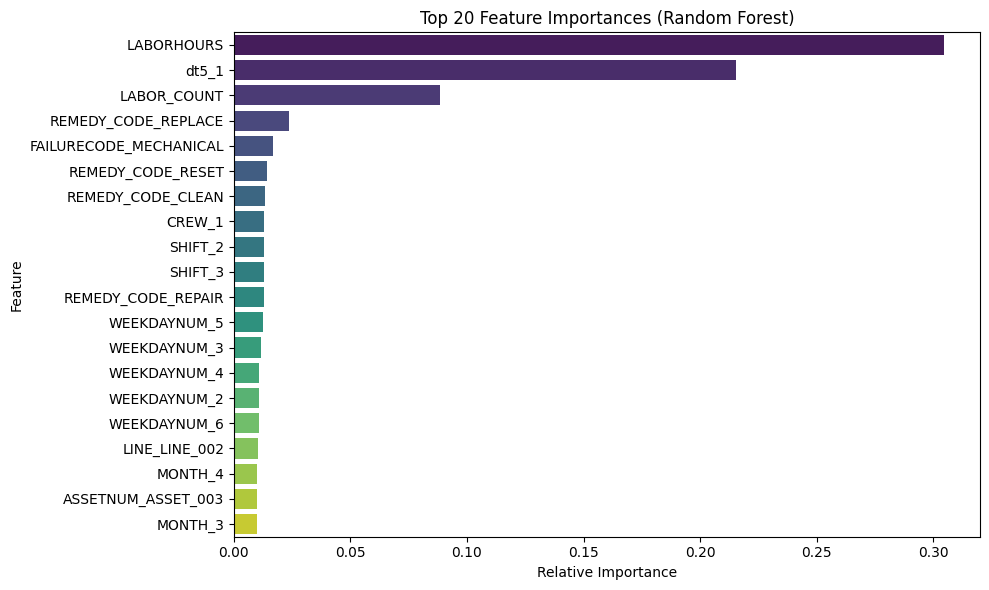

In [52]:
# Get feature importances
importances = best_rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_imp = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Show top 20
top_feats = feat_imp.head(20)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_feats, palette='viridis')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

### XGBoost

In [53]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.5],
    'reg_lambda': [1, 2]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train, y_train)

# Get the best parameters
best_xgb = grid_search_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
r2_xgb = r2_score(y_test, xgb_pred)

print(f"\n Tuned Random Forest Results:")
print(f"   Best Params: {grid_search_xgb.best_params_}")
print(f"   RMSE (log scale): {rmse_xgb:.4f}")
print(f"   R²: {r2_xgb:.4f}")

# Getting original RMSE
rmse_minutes = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(xgb_pred)))
print(f"   RMSE (minutes): {rmse_minutes:.2f}")

Fitting 3 folds for each of 576 candidates, totalling 1728 fits

 Tuned Random Forest Results:
   Best Params: {'colsample_bytree': 1, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.5, 'reg_lambda': 2, 'subsample': 0.8}
   RMSE (log scale): 0.6107
   R²: 0.7610
   RMSE (minutes): 400.28


### LightGBM

In [54]:
lgbm = lgb.LGBMRegressor(objective='regression', random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

lgbm = lgb.LGBMRegressor(objective='regression', random_state=42)

grid_search_lgb = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search_lgb.fit(X_train, y_train)

# Get the best parameters
best_lgb = grid_search_lgb.best_estimator_
lgb_pred = best_lgb.predict(X_test)

# Evaluate
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_pred))
r2_lgb = r2_score(y_test, lgb_pred)

print(f"\n Tuned Random Forest Results:")
print(f"   Best Params: {grid_search_lgb.best_params_}")
print(f"   RMSE (log scale): {rmse_lgb:.4f}")
print(f"   R²: {r2_lgb:.4f}")

# Getting original RMSE
rmse_minutes = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(lgb_pred)))
print(f"   RMSE (minutes): {rmse_minutes:.2f}")

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 1346, number of used features: 44
[LightGBM] [Info] Start training from score 3.620581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [55]:
lgb.plot_importance(best_lgb, max_num_features=10, importance_type='gain', figsize=(10, 6))
plt.title("LightGBM - Top 10 Features")
plt.show()

## Model Evaluation

#### Evaluation Metrics

To assess model performance, the following evaluation metrics:

Evaluation Metrics
1. RMSE (Root Mean Squared Error) on both:
  - Log-scaled downtime - to stabilize variance and reduce skew
  - Original scale (in minutes) - to interpret predictions in real-world units

2. R$^2$ Score  proportion of variance explained by the model



#### Validation Strategy

The validation strategies utilized are listed below:

1. Train/Test Split:

  - 70/30 split to ensure unbiased evaluation

2. Cross-Validation (5-fold):

  -  Used to select optimal alpha values on Ridge and Lasso

3. Grid Search with 3-fold CV:

  - Used to tune Random Forest hyperparameters

#### Hyperparameters

Each of the tree-based models utilized GridSearchCV to tune the parameters.

I just let ChatGPT set up the parameters for me and rocked with it.

#### Evaluation Metric Summary

Results of the evaluation metrics are summarized in the table below:

In [56]:
# Define your models and labels
models = {
    'Linear Regression': lr,
    'Ridge Regression': ridge,
    'Lasso Regression': lasso,
    'Random Forest': best_rf,
    'XGBoost': best_xgb,
    'LightGBM': best_lgb
}

# Initialize list to hold results
results = []

# Loop through each model
for name, model in models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    r2_log = r2_score(y_test, y_pred_log)
    rmse_minutes = np.sqrt(mean_squared_error(y_true, y_pred))

    results.append({
        'Model': name,
        'RMSE (log)': rmse_log,
        'R²': r2_log,
        'RMSE (minutes)': rmse_minutes
    })

# Create DataFrame
comparison_df = pd.DataFrame(results).round(3)

# Display sorted by RMSE in minutes
comparison_df = comparison_df.sort_values('RMSE (minutes)')
display(comparison_df)

Model  RMSE (log)     R²  RMSE (minutes)
5           LightGBM       0.610  0.762         395.257
4            XGBoost       0.611  0.761         400.279
3      Random Forest       0.718  0.669         414.528
2   Lasso Regression       0.855  0.531        2183.170
1   Ridge Regression       0.862  0.524        2203.501
0  Linear Regression       0.865  0.521        2926.111

## Model Interpretation

### Tree-Based vs. Parametric Models

The results of this data show a great difference in the power of tree-based models such as the Random Forest model and the two gradient boost models. Training on this dataset proves to be fairly difficult as there is a decent bit of variation in the data with a decent bit of outliers while having little observations. The tree-models greatly outperformed the MLR and shrinkage models.

I imagine the struggle that the Lasso, Ridge and Linear models experienced came about due to the nonlinearity of the major features such as the labor hours and labor count. The number of high cardinality categorical variables may also been an additional hurdle they could not cross well.

Another advantage that the tree-based models have is the ability to capture the interactions between the features without complex manual feature engineering requirements from the parametric models. The dataset with he given features are just too complex for accurate prediction from the linear models.

The key advantages of the tree-based models:
1. Ability to handle nonlinearity
2. Ability to handle high cardinality variables
3. Ability to capture feature interactions

### Gradient Boosting vs. Bagging

To comment on the success of the LightGBM over the XGBoost and Random Forest, I honestly got all three of them switching spots before I settled on doing a gridsearch for all 3. I imagine the main factor is how well hyperparameter tuning goes, but gradient boosting has a slight edge since it has a "Gross-to-Fine" approach as opposed to the parallel/bagging method from the Random Forest.

### Feature Importance

The top 3 features for the models in the dataset are LABORHOURS, LABOR_COUNT, and DT5. This would make sense as with more downtime, more people would work on it and more man hours would be spent on it. Also, it would be easy to predict close to the amount of downtime if  downtime<=5 is true... at least within 5 minutes. Other features did not have near as significant of an impact as those three features.

## Conclusion

This project explored the predictive modeling of downtime using an anonymized real-world maintenance dataset. Through exploratory analysis, it became evident that the most influential features in the models are Labor Count, Labor Hours, and DT<=5. Unfortunately, these would not truly be that useful as predictors as labor hours and count are consequences of downtime event and dt under 5 is directly related to the downtime. Due to the lack of significant features, I did keep them in there, but they should be recognized as not being very useful. When writing the query up, intentions were to create several potential target variables so many variables may be analyzed. For the scope and time constraint of this project, I only set one target variable, but more analysis will be necessary to get the most out of this dataset.


The modeling process highlighted the challenges of working with limited and noisy data. Parametric models such as MLR, Ridge, and Lasso regression struggled to capture the complexity of the data, likely due to nonlinear relationships and high-cardinality categorical variables. In contrast, tree-based models (Gradient Boosting and Random Forest), performed significantly better by naturally handling these complexities and feature interactions.


While the prediction may not be that strong if removing the predictors mentioned above, this project has given me insight on key details to watch for when engineering the features. Given the dataset collected, modeling proved to be slightly complex, but this data was only collected from a small subset of workorders. Applying the ideas from *Unreasonable Effectiveness of Data*, we could pull a much larger query and we may even be able to get strong predictive power from features such as HNACOMMODITY or LEAD.

Overall, while the models did not yield highly actionable predictions in this iteration, the workflow built here lays a strong foundation for future data-driven maintenance optimization efforts.